# Demos
* Plotting brains with [Nilearn](http://nilearn.github.io)
* Text to speech with [pyttsx3](https://pyttsx3.readthedocs.io)
* Sentiment analysis with [Pliers](https://github.com/tyarkoni/pliers)
* Extracting relations between phrases and entities using [spacy](https://spacy.io)
* Tagging POS (part-of-speech)

These slides should only give you a clue what you could do with python. You don't need to understands what happens.

# Plotting brains with [Nilearn](http://nilearn.github.io)

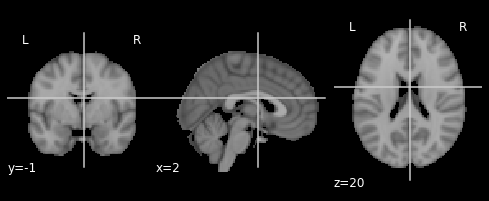

In [1]:
# First, we fetch and load the default anatomical image available in Nilearn datasets module
from nilearn import datasets

# default MNI152 template
anatomical_image = datasets.load_mni152_template()

# Then, import plotting module from nilearn to easily visualize the loaded image
from nilearn import plotting

# To plot anatomical image
plotting.plot_anat(anatomical_image)

We can also plot some stat-maps

/Users/fliem/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py:2349: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


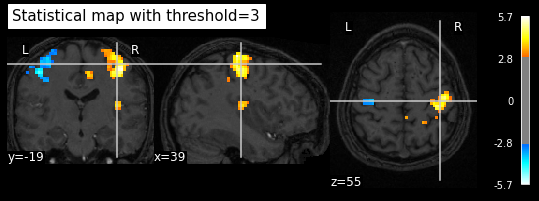

In [2]:
localizer_dataset = datasets.fetch_localizer_button_task()
# Contrast map of motor task
localizer_tmap_filename = localizer_dataset.tmap
# Subject specific anatomical image
localizer_anat_filename = localizer_dataset.anat

# Visualizing t-map with `threshold=3` based on its statistical intensities
plotting.plot_stat_map(localizer_tmap_filename, bg_img=localizer_anat_filename,
                       threshold=3,
                       title="Statistical map with threshold=3")

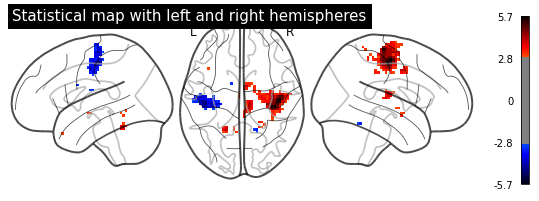

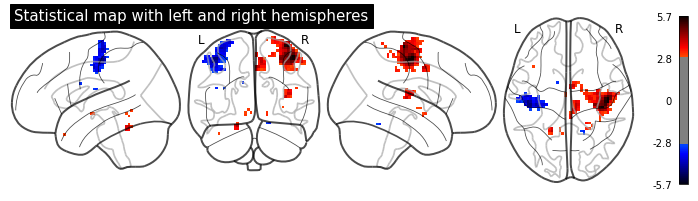

In [3]:
plotting.plot_glass_brain(localizer_tmap_filename, threshold=3, plot_abs=False, display_mode="lzr",
                         colorbar=True, title="Statistical map with left and right hemispheres")
plotting.plot_glass_brain(localizer_tmap_filename, threshold=3, plot_abs=False,  display_mode="lyrz",
                         colorbar=True, title="Statistical map with left and right hemispheres")

# Text to speech with [pyttsx3](https://pyttsx3.readthedocs.io)
Example adapted from their [documentation](https://pyttsx3.readthedocs.io/en/latest/engine.html#module-pyttsx3.voice)

In [4]:
import pyttsx3
engine = pyttsx3.init()
voices = engine.getProperty('voices')
for voice in voices[:5]:
    print(voice.languages)
    engine.setProperty('voice', voice.id)
    engine.say('The quick brown fox jumped over the lazy dog.')
engine.runAndWait()

['en_US']
['it_IT']
['sv_SE']
['fr_CA']
['de_DE']


# Sentiment analysis with [Pliers](https://github.com/tyarkoni/pliers)

A Python package for automated extraction of features from multimodal stimuli.

Can interface with other services (e.g. Google cloud services)

Example from plier's quickstart [notebook](https://github.com/PsychoinformaticsLab/pliers/blob/master/examples/Quickstart.ipynb)

In [5]:
from pliers.stimuli import TextStim, ComplexTextStim
from pliers.extractors import VADERSentimentExtractor, merge_results
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/fliem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/fliem/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [6]:
raw = "This was not good but terrible"

text = ComplexTextStim(text=raw)
ext = VADERSentimentExtractor()
results = ext.transform(text)
df = merge_results(results, object_id=False)
df[["stim_name", "VADERSentimentExtractor#sentiment_neg", "VADERSentimentExtractor#sentiment_pos"]]

Stim: 6it [00:00, 6218.39it/s]


,stim_name,VADERSentimentExtractor#sentiment_neg,VADERSentimentExtractor#sentiment_pos
0,text[This],0.0,0.0
1,text[was],0.0,0.0
2,text[not],0.0,0.0
3,text[good],0.0,1.0
4,text[but],0.0,0.0
5,text[terrible],1.0,0.0


# Extracting relations between phrases and entities using [spacy](https://spacy.io)
Adapted from their [examples](https://github.com/explosion/spaCy/blob/master/examples/information_extraction/entity_relations.py)

    A simple example of extracting relations between phrases and entities using
    spaCy's named entity recognizer and the dependency parse. Here, we extract
    money and currency values (entities labelled as MONEY) and then check the
    dependency tree to find the noun phrase they are referring to – for example:
    $9.4 million --> Net income.

Run the following in your terminal before starting this notebook
```bash
python -m spacy download en_core_web_sm
```

Also, we first need a bunch of helper code.

In [7]:
from __future__ import unicode_literals, print_function
import plac
import spacy

def filter_spans(spans):
    # Filter a sequence of spans so they don't contain overlaps
    # For spaCy 2.1.4+: this function is available as spacy.util.filter_spans()
    def get_sort_key(span): return (span.end - span.start, -span.start)
    sorted_spans = sorted(spans, key=get_sort_key, reverse=True)
    result = []
    seen_tokens = set()
    for span in sorted_spans:
        # Check for end - 1 here because boundaries are inclusive
        if span.start not in seen_tokens and span.end - 1 not in seen_tokens:
            result.append(span)
        seen_tokens.update(range(span.start, span.end))
    result = sorted(result, key=lambda span: span.start)
    return result


def extract_currency_relations(doc):
    # Merge entities and noun chunks into one token
    spans = list(doc.ents) + list(doc.noun_chunks)
    spans = filter_spans(spans)
    with doc.retokenize() as retokenizer:
        for span in spans:
            retokenizer.merge(span)

    relations = []
    for money in filter(lambda w: w.ent_type_ == "MONEY", doc):
        if money.dep_ in ("attr", "dobj"):
            subject = [w for w in money.head.lefts if w.dep_ == "nsubj"]
            if subject:
                subject = subject[0]
                relations.append((subject, money))
        elif money.dep_ == "pobj" and money.head.dep_ == "prep":
            relations.append((money.head.head, money))
    return relations

In [8]:
TEXTS = [
    "Net income was $9.4 million compared to the prior year of $2.7 million.",
    "Revenue exceeded twelve billion dollars, with a loss of $1b.",
]

nlp = spacy.load("en_core_web_sm")
for text in TEXTS:
    doc = nlp(text)
    relations = extract_currency_relations(doc)
    for r1, r2 in relations:
        print("{:<10}\t{}".format(r1.text, r2.text))

Net income	$9.4 million
the prior year	$2.7 million
Revenue   	twelve billion dollars
a loss    	1b


## Tagging POS (part-of-speech)

In [9]:
import spacy
import pandas as pd

nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

df = pd.DataFrame()
for token in doc:
    df = df.append({"text":token.text, "lemma":token.lemma_, "pos":token.pos_},ignore_index=True)
df[["text", "lemma", "pos"]]

,text,lemma,pos
0,Apple,Apple,PROPN
1,is,be,AUX
2,looking,look,VERB
3,at,at,ADP
4,buying,buy,VERB
5,U.K.,U.K.,PROPN
6,startup,startup,NOUN
7,for,for,ADP
8,$,$,SYM
9,1,1,NUM
